In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RandomizedLasso
from treeinterpreter import treeinterpreter as ti
from graphviz import Source
from IPython.display import SVG,display, Image
from sklearn.tree import export_graphviz
import pydot
from subprocess import call
% matplotlib inline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn import svm
#from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RepeatedEditedNearestNeighbours, TomekLinks, NearMiss,  AllKNN
from collections import Counter

### import data

In [4]:
raw_data=pd.read_csv('Telco.csv')
raw_data['TotalCharges']=raw_data['TotalCharges'].convert_objects(convert_numeric=True)
raw_data.dropna(inplace=True)
raw_data.reset_index(inplace=True)
raw_data=raw_data.drop(['index','customerID'],axis=1)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


### select features

In [5]:
data=pd.get_dummies(raw_data)
data=data.drop('Churn_No',axis=1)

In [79]:
X=data.drop('Churn_Yes',axis=1)
y=data['Churn_Yes']

In [80]:
from sklearn import preprocessing
std_scale = preprocessing.MinMaxScaler().fit(X)
X_s = std_scale.transform(X)

In [47]:
from sklearn.linear_model import LassoCV
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel,SelectKBest
from sklearn.ensemble import ExtraTreesClassifier

In [81]:
lsvc = LinearSVC(C=0.1, penalty="l1", dual=False).fit(X_s, y)
model = SelectFromModel(lsvc,prefit=True)
l1_features = model.get_support(indices = False) 
l1_features=[list(X.columns)[i] for i in range(len(X.columns)) if features[i]==True]

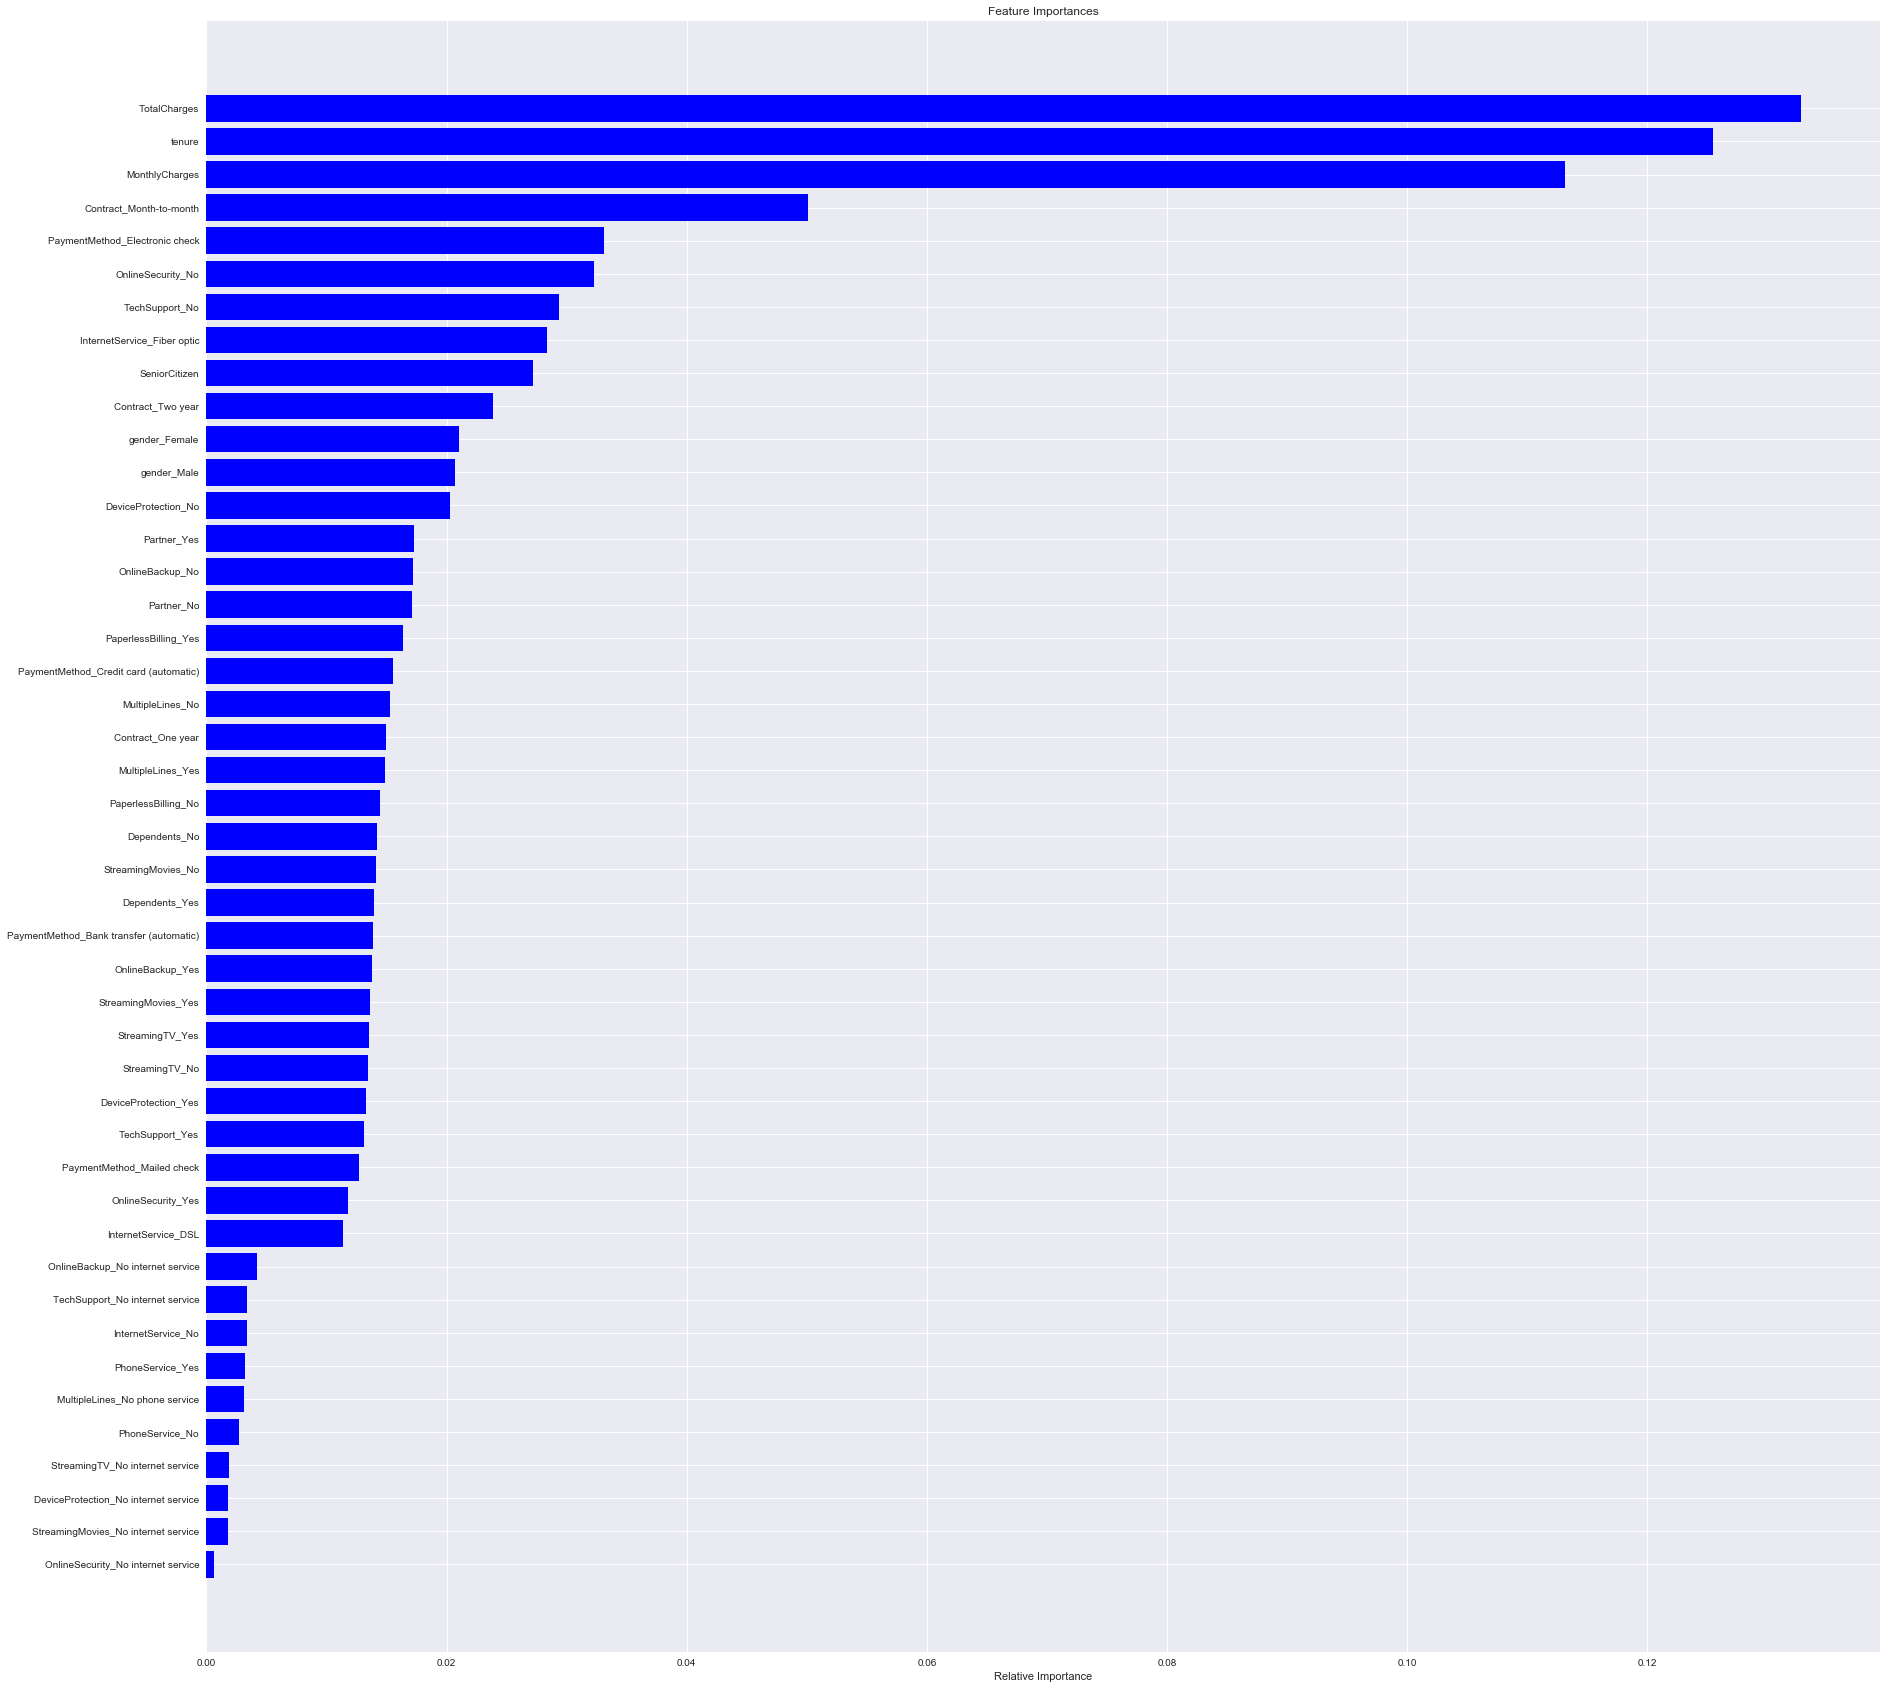

In [82]:
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
features = data.columns
importances = clf.feature_importances_
indices = np.argsort(importances)
rf_features=[features[i] for i in indices][-12:]
plt.figure(figsize=(30,30))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [83]:
feat=list(set(l1_features+rf_features))

In [85]:
X=X[feat]

### split the data

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y, 
                                                        test_size=0.3,
                                                        stratify=y,
                                                        random_state=1)

### model 0 : LR simple

In [89]:
clf = LogisticRegression(C=0.1, penalty='l2', class_weight='balanced')
clf.fit(X_train,y_train)
predictions = clf.predict(X_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

             precision    recall  f1-score   support

          0       0.90      0.72      0.80      1549
          1       0.51      0.79      0.62       561

avg / total       0.80      0.74      0.75      2110

[[1117  432]
 [ 119  442]]


### model 1 : undersample the majority

In [103]:
AK= AllKNN(allow_minority=True, sampling_strategy='majority')
X_res, y_res = AK.fit_sample(X_train, y_train)

In [104]:
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_res).items()))

[(0, 3614), (1, 1308)]
[(0, 1883), (1, 1308)]


In [105]:
clf = LogisticRegression(C=0.1, penalty='l2', class_weight='balanced')
clf.fit(X_res,y_res)
predictions = clf.predict(X_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

             precision    recall  f1-score   support

          0       0.93      0.59      0.72      1549
          1       0.43      0.87      0.58       561

avg / total       0.80      0.66      0.68      2110

[[912 637]
 [ 71 490]]


### model 2 : undersample + smote

In [106]:
from imblearn.over_sampling import SMOTE
AK= AllKNN(allow_minority=True, sampling_strategy='majority')
X_res, y_res = AK.fit_sample(X_train, y_train)
smote = SMOTE(sampling_strategy='all')
X_sm, y_sm = smote.fit_sample(X_res, y_res)

In [107]:
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_res).items()))
print(sorted(Counter(y_sm).items()))

[(0, 3614), (1, 1308)]
[(0, 1883), (1, 1308)]
[(0, 1883), (1, 1883)]


In [108]:
clf = LogisticRegression(C=0.1, penalty='l2', class_weight='balanced')
clf.fit(X_sm,y_sm)
predictions = clf.predict(X_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

             precision    recall  f1-score   support

          0       0.93      0.59      0.72      1549
          1       0.44      0.87      0.58       561

avg / total       0.80      0.67      0.69      2110

[[916 633]
 [ 71 490]]


In [111]:
rf = RandomForestClassifier()
rf.fit(X_sm,y_sm)
predictions = clf.predict(X_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

             precision    recall  f1-score   support

          0       0.92      0.61      0.74      1549
          1       0.44      0.85      0.58       561

avg / total       0.79      0.68      0.70      2110

[[950 599]
 [ 83 478]]


In [110]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [113]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_sm,y_sm)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   2.9s
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   2.9s
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   2.8s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bo

[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False, total=  15.6s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=   8.0s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=   7.3s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=   6.4s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total=  14.8s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=2

[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False, total=  11.4s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, total=   8.1s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=  10.9s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=  10.7s
[CV] n_estimators

[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   5.0s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   4.7s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False, total=   5.5s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=  10.8s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1800,

[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   6.9s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   6.6s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   6.4s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=400, min_samples_sp

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.6min


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=   7.1s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=   7.0s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False, total=  14.1s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False, total=  13.6s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimat

[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False, total=   7.1s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=   9.0s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=   9.9s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=   9.1s
[CV] n_

[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=True 
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=   3.0s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=   3.3s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=True, total=  10.9s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=400, min_samples

[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=   4.8s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=   4.9s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=   4.9s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total=   3.3s
[CV] n_estimators=1600, m

[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=   1.3s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=   6.6s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=   6.7s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=   1.3s
[CV] n_estimators=2000

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.7min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring=None, verbose=2)

In [114]:
predictions = rf_random.predict(X_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

             precision    recall  f1-score   support

          0       0.93      0.59      0.72      1549
          1       0.44      0.88      0.58       561

avg / total       0.80      0.67      0.69      2110

[[915 634]
 [ 68 493]]
